In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class MyRFECV(object):
    
    def __init__(self, estimator, step, cv, features):
        self.estimator = estimator
        self.step = step
        self.cv = cv
        self.features = features
        
    def _score(self, labels, probs):
        
        names = ['b', 'c', 'sud', 'gluon']
        roc_auc = utils.get_roc_auc_matrix(labels, probs, names, save_path=None, show=False)
        return roc_auc.values.mean()
        
    def _fit_step(self, data, features):
        sk = SklearnClassifier(self.estimator, features=None)
        folding = FoldingClassifier(sk, n_folds=self.cv, random_state=11, features=features)
        folding.fit_lds(data)
        importances = folding.feature_importances_
        indices = numpy.argsort(importances)[::-1]
        
        labels = data.target
        probs = folding.predict_proba(data.data)
        score = self._score(labels, probs)
        
        return features[indices], score
        
    def fit(self, data):
        features = self.features
        feature_list = []
        score_list = []
        
        while len(features) >= self.step:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
            features = features[:-self.step]
            
        if len(features) > 0:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
        return numpy.array(feature_list), numpy.array(score_list)

In [3]:
%matplotlib inline
import root_numpy
import pandas
import numpy
import matplotlib.pyplot as plt
from rep.data import LabeledDataStorage
#from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier
import cPickle as pickle

## Read data

In [4]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::90]
data_c = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=0.root', treename=treename)).dropna()
data_light = data_light[::2]

In [5]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

In [6]:
full_data = pandas.concat([data_b, 
                           data_c, 
                           data_light[data_light.JetParton != 0], 
                           data_light[data_light.JetParton == 0]])

full_data['label'] = [0] * len(data_b) + \
                     [1] * len(data_c) + \
                     [2] * len(data_light[data_light.JetParton != 0]) + \
                     [3] * len(data_light[data_light.JetParton == 0])

In [7]:
names = ['b', 'c', 'sud', 'gluon']

In [8]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

# Multiclassification

## Data preprocessing

In [9]:
train_data = full_data[sv_features].values
labels = full_data['label'].values

## Train

In [ ]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time multi_folding.fit(train_data, labels)

In [ ]:
multi_probs = multi_folding.predict_proba(train_data)

## Results

In [ ]:
import os, sys
sys.path.append('python')
import utils

In [ ]:
from sklearn.metrics import log_loss

print 'Log loss is ', log_loss(labels, multi_probs)

In [ ]:
def get_learning_curve(clf, data, labels):

    n_estimators = clf.get_params()['base_estimator__n_estimators']
    staged_probas = clf.staged_predict_proba(data)

    from sklearn.metrics import log_loss
    log_loss_all = []
    for pred in staged_probas:
        log_loss_all.append(log_loss(labels, pred))

    x = numpy.arange(10, n_estimators + 10, 10)
    plt.plot(x, log_loss_all)
    plt.ylabel('Log loss')
    plt.xlabel('Iteration')
    plt.show()

In [ ]:
get_learning_curve(multi_folding, train_data, labels)

In [ ]:
roc_auc_baseline = utils.get_roc_auc_matrix(labels, multi_probs, names, save_path=None, show=True)
roc_auc_baseline

# Keras MLP

In [18]:
from copy import copy
from sklearn.preprocessing import MinMaxScaler, Imputer, StandardScaler

class Preprocessor(object):
    
    def __init__(self, missing_values, copy=True):
        self.missing_values = missing_values
        self.copy = copy
        
    def fit(self, X):
        
        X_copy = copy(X)
                
        imputer = Imputer(missing_values=self.missing_values, strategy='median', axis=0, copy=False)
        imputer.fit(X_copy)
        self.imputer = imputer
                
        mms = MinMaxScaler(feature_range=(0, 100), copy=False)
        mms.fit(X_copy)
        self.mms = mms
        
        X_copy = mms.transform(X_copy)
        sing = (X_copy > 0) * 2. - 1.
        X_copy = numpy.log(1. + numpy.abs(X)) * sing
            
        ss = StandardScaler(copy=False, with_mean=True, with_std=True)
        ss.fit(X_copy)
        self.ss = ss
            
    def transform(self, X):
        
        if self.copy == True:
            input_data = copy(X)
        else:
            input_data = X
            
            
        input_data = self.imputer.transform(input_data)
            
        input_data = self.mms.transform(input_data)
        sing = (input_data > 0) * 2. - 1.
        input_data = numpy.log(1. + numpy.abs(input_data)) * sing
            
        input_data = self.ss.transform(input_data)
                
        return input_data

In [16]:
from rep.utils import train_test_split
train_train_data, test_data, train_labels, test_labels = train_test_split(train_data, labels, test_size=0.3)

In [72]:
test_data.shape

(18492, 9)

In [19]:

prep = Preprocessor(missing_values=-999., copy=True)
prep.fit(train_train_data)

In [20]:
from keras.utils import np_utils

X_train = prep.transform(train_train_data)
y_train = np_utils.to_categorical(train_labels)

X_test = prep.transform(test_data)
y_test = np_utils.to_categorical(test_labels)

In [104]:
%%time
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, activity_l2, l1, activity_l1, l1l2

clf = Sequential()
clf.add(Dense(100, input_dim=X_train.shape[1], init='uniform', activation='sigmoid'))
#clf.add(Activation('sigmoid'))
clf.add(Dropout(0.5))
clf.add(Dense(4, init='uniform', activation='softmax'))
#clf.add(Activation('sigmoid'))
#clf.add(Activation('softmax'))

ada = Adadelta(lr=1., rho=0.95, epsilon=1e-06)
sgd = SGD(lr=0.02, decay=0.0, momentum=0.0, nesterov=False)

clf.compile(loss='categorical_crossentropy',
              optimizer=sgd,
             class_mode = "categorical")

call = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')


history = clf.fit(X=X_train, 
                y=y_train, 
                #sample_weight=weights_train,
                nb_epoch=2000,
                batch_size=1000,
                show_accuracy=True,
                validation_split=0.1,
                validation_data = (X_test, y_test),
                verbose=0,
                callbacks=[])

CPU times: user 22min 46s, sys: 1h 12min 39s, total: 1h 35min 26s
Wall time: 13min 46s


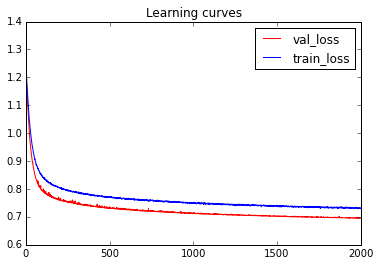

In [105]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.title('Learning curves')
plt.plot(val_loss, 'r', label='val_loss')
plt.plot(loss, 'b', label='train_loss')
plt.legend(loc='best')
plt.show()

In [106]:
prob_mlp = clf.predict_proba(X_test)

18492/18492 [==============================] - 0s     


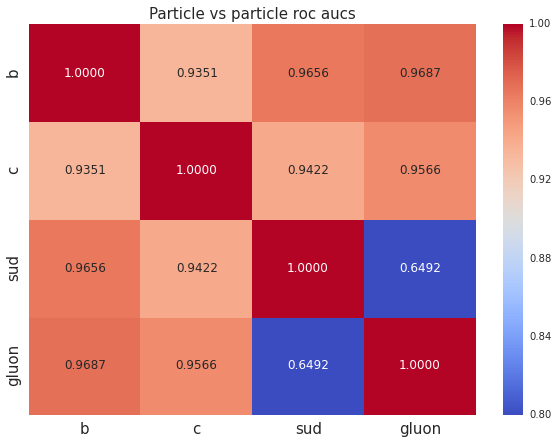

,b,c,sud,gluon
b,1.000000,0.935058,0.965564,0.968685
c,0.935058,1.000000,0.942153,0.956609
sud,0.965564,0.942153,1.000000,0.649234
gluon,0.968685,0.956609,0.649234,1.000000


In [107]:
import os, sys
sys.path.append('python')
import utils
mlp_roc_aucs = utils.get_roc_auc_matrix(test_labels, prob_mlp, names, save_path=None, show=True)
mlp_roc_aucs

In [108]:
mlp_roc_aucs - roc_auc_baseline

,b,c,sud,gluon
b,0.000000,-0.014408,-0.017469,-0.013874
c,-0.014408,0.000000,-0.028645,-0.017747
sud,-0.017469,-0.028645,0.000000,-0.010024
gluon,-0.013874,-0.017747,-0.010024,0.000000
